In [47]:
from fastdtw import fastdtw

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import neo

import numpy as np

from scipy.cluster.hierarchy import dendrogram, linkage, fcluster

import tqdm

In [8]:
fname = '../neuro_data/pattern_data/LT1D01.28.nex'
r = neo.io.NeuroExplorerIO(fname)

for blk in r.read(cascade=True, lazy=False):
    for seg in blk.segments:
        for sig in seg.analogsignals:
            pass

In [29]:
def extract_spikes(sig, width, height):
    waveforms = list()
    idx = width//2
    while idx < sig.shape[0]:
        if sig[idx] >= height:
            waveforms.append(sig[idx-width//2:idx+width//2])
            idx += width//2
        else:
            idx += 1
    
    return waveforms    

In [30]:
sig_data = np.array(sig).flatten()

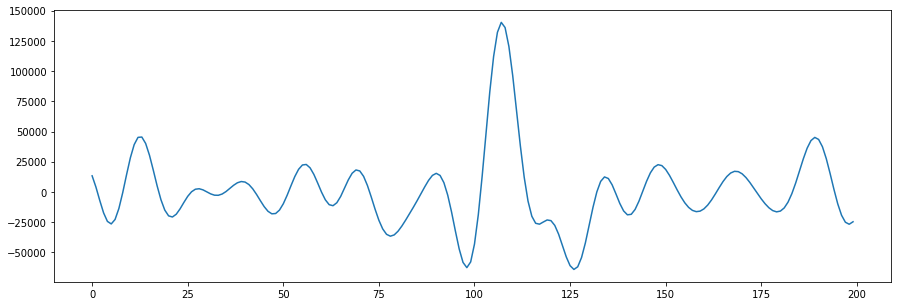

In [31]:
plt.figure(figsize=(15,5))
plt.plot(sig_data[2500:2700])

In [40]:
waveforms = extract_spikes(sig_data, 30, 100000)

In [50]:
from scipy.spatial.distance import euclidean

def dtw_metric(x, y):
    distance, path = fastdtw(x, y, dist=euclidean)
    
    return distance

def build_matrix(arr, metric):
    res = np.zeros((len(arr), len(arr)), dtype=float)
    
    for i in tqdm.tnrange(len(arr)):
        for j in range(i + 1, len(arr)):
            m = metric(arr[i], arr[j])
            if np.isfinite(m):
                res[i,j] = res[j, i] = m
            else:
                res[i,j] = res[j, i] = 1.
    
    return res

In [51]:
M = build_matrix(waveforms, dtw_metric)

A Jupyter Widget

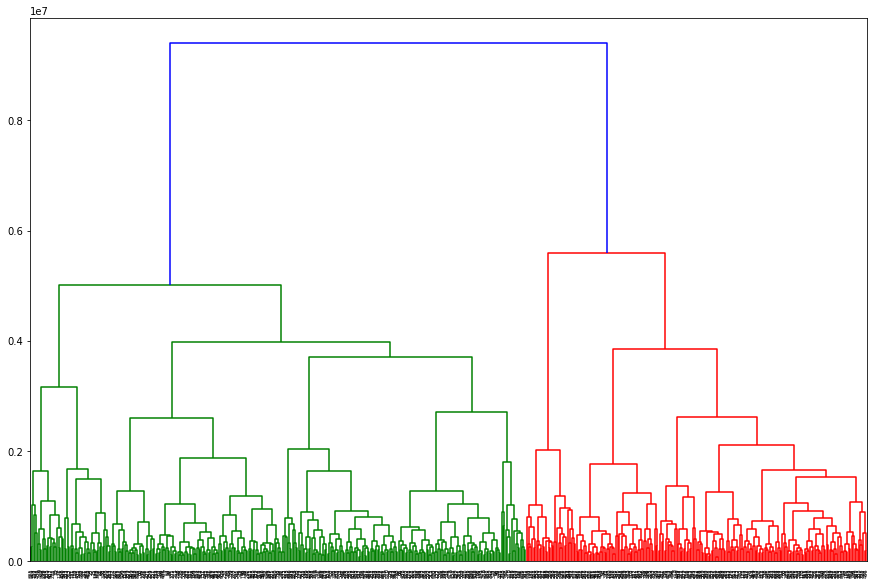

In [53]:
Z_isi = linkage(M[np.triu_indices(M.shape[0], 1)], 'ward')

plt.figure(figsize=(15,10))
d_dct = dendrogram(Z_isi)

In [73]:
labels = fcluster(Z_isi, 0.5*1e7, 'distance')
print(np.unique(labels))

[1 2 3 4]


In [74]:
waveforms_np = np.array(waveforms)

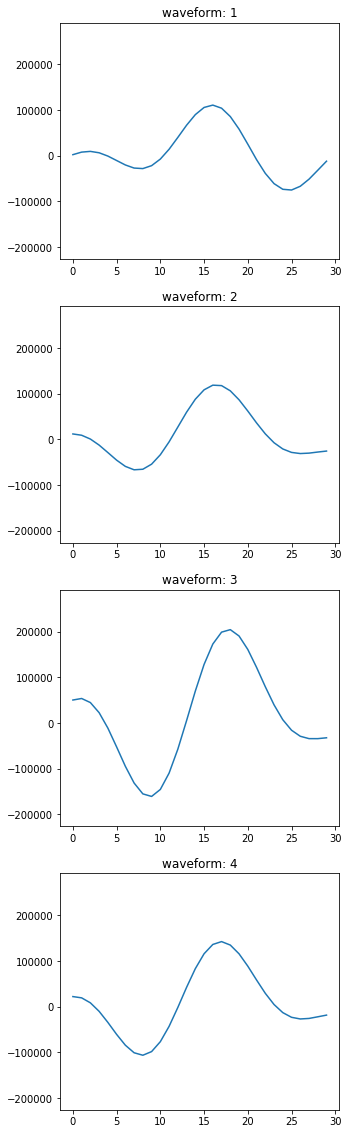

In [77]:
f, axes = plt.subplots(nrows=len(np.unique(labels)), figsize=(5, 5*len(np.unique(labels))))

for idx, l in enumerate(np.unique(labels)):
    form = np.mean(waveforms_np[labels == l], axis=0)
    
    axes[idx].plot(form)
    
    axes[idx].set_ylim([np.min(waveforms_np), np.max(waveforms_np)])
    axes[idx].set_title('waveform: {}'.format(l))